In [258]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [259]:
df_products = pd.read_csv('data/processed_prod_data.csv')


/var/folders/3_/49qq58ns2r11fnng7d9pbd0w0000gn/T/ipykernel_10117/2061017201.py:1: DtypeWarning:

Columns (15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.



### Vis for all product options

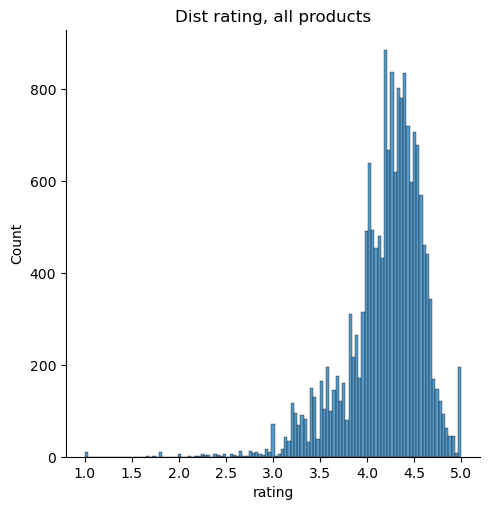

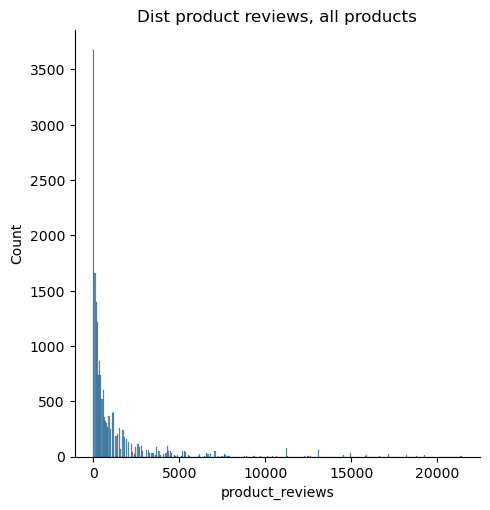

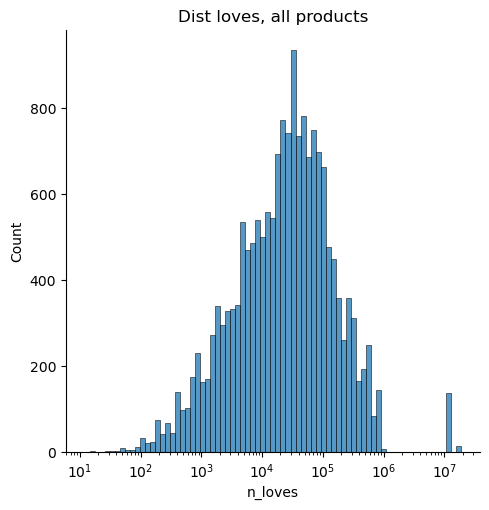

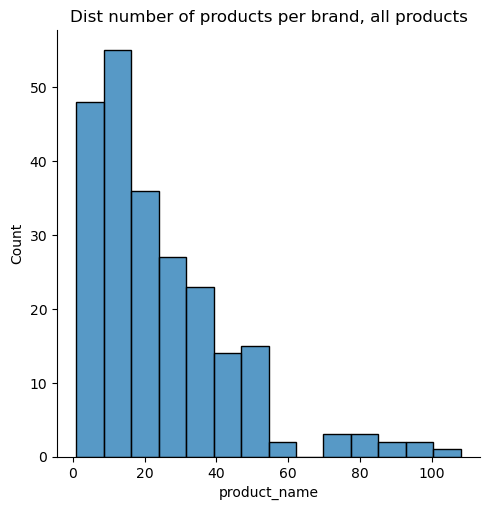

,brand_name,product_name
184,sephora collection,108
122,kérastase,98
24,bumble and bumble,93
209,tom ford,91
133,mac cosmetics,90


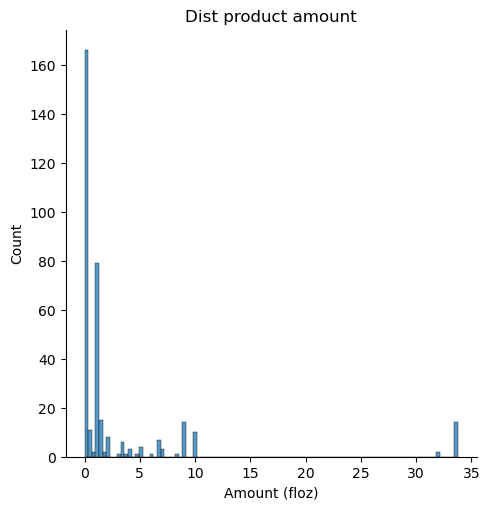

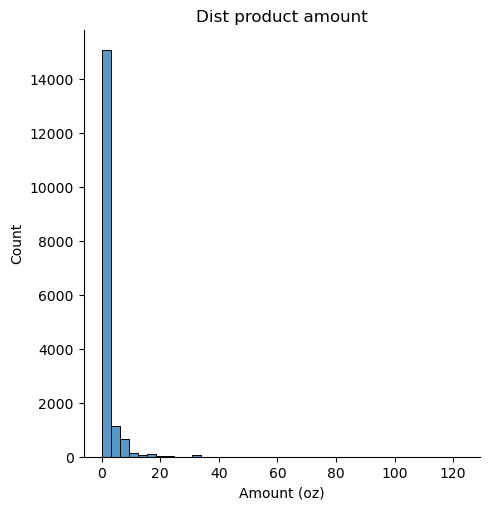

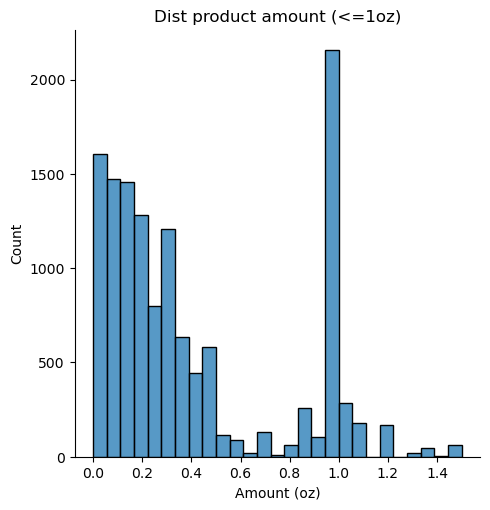

In [293]:

sns.displot(data=df_products, x="rating")
plt.title('Dist rating, all products')
plt.show()

sns.displot(data=df_products, x="product_reviews")#, log_scale=True)
plt.title('Dist product reviews, all products')
plt.show()

sns.displot(data=df_products, x="n_loves", log_scale=True)
plt.title('Dist loves, all products')
plt.show()

prods_per_brand = df_products.groupby('brand_name', as_index=False)['product_name'].nunique()
sns.displot(data=prods_per_brand, x="product_name")
plt.title('Dist number of products per brand, all products')
plt.show()
display(prods_per_brand.sort_values(by='product_name', ascending=False).head())

sns.displot(data=df_products[df_products['unit_a']=='floz'], x="amount_a")
plt.title('Dist product amount')
plt.xlabel('Amount (floz)')
plt.show()

sns.displot(data=df_products[df_products['unit_a']=='oz'], x="amount_a", bins=40)
plt.title('Dist product amount')
plt.xlabel('Amount (oz)')
plt.show()

sns.displot(data=df_products[(df_products['unit_a']=='oz') & (df_products['amount_a']<=1.5)], x="amount_a")
plt.title('Dist product amount (<=1oz)')
plt.xlabel('Amount (oz)')
plt.show()

# sns.displot(data=df_products[df_products['unit_a']=='floz'], x="unit_price",log_scale=True)
# plt.title('Dist unit price, floz products')
# plt.xlabel('log(Unit price) ($/floz)')
# plt.show()

# sns.displot(data=df_products, x="unit_price", log_scale=True)
# plt.title('Unit price distribution')
# plt.xlabel('log(Unit price ($/oz)) ')
# plt.tight_layout()
# plt.show()

In [294]:
df_products.groupby(['unit_a','unit_b'])['internal_product_id'].count()

unit_a  unit_b
floz    g             1
        ml          350
oz      g          5986
        kg            1
        l            15
        mg            1
        ml        11278
Name: internal_product_id, dtype: int64

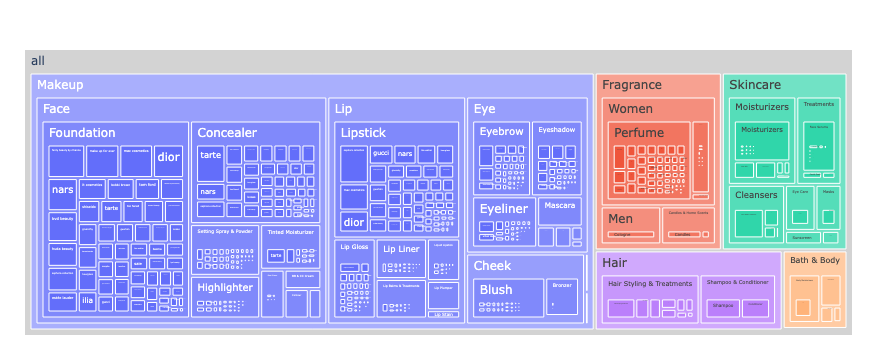

In [262]:

df_products_tree = df_products.groupby(['lvl_0_cat', 'lvl_1_cat', 'lvl_2_cat','brand_name'], as_index=False)['internal_product_id'].count()
fig = px.treemap(df_products_tree, path=[px.Constant("all"), 'lvl_0_cat', 'lvl_1_cat', 'lvl_2_cat','brand_name'], values='internal_product_id')
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

# what is a single product ?

[brand_name, product_name, swatch_group, size, price]
 - if price is used and only some options are on sale, this would create duplicates
 - if price is left out of group-by, what is the best way to aggregate? max?
 
 - aggregated values like rating, product_reviews, n_loves should be same for all options of product?


https://www.sephora.com/ca/en/product/P434104?skuId=2407302

as each swatch group is clicked, sku in url changes
- a single product can have multiple skus depending on colour
- a single product can have multiple skus depending on size 


### Comparing standard with mini sizes

In [263]:
df = df_products.groupby(['product_id','product_name', 'brand_name', 'swatch_group','amount_a'], as_index=False).agg({
    'price':'max',
    'internal_product_id':'nunique',
    'rating':'max',
    'product_reviews':'max',
    'n_loves':'max',
    'lvl_0_cat':'first',
    'lvl_1_cat':'first',
    'lvl_2_cat':'first',
    'sku':'unique',
    'amount_b':'first',
    'unit_b':'first',
    'product_multiplier':'first'
})

df['amount_a_adjusted'] = df['amount_a'] * df['product_multiplier'].astype('float')
df['unit_price'] = df['price']/df['amount_a_adjusted']

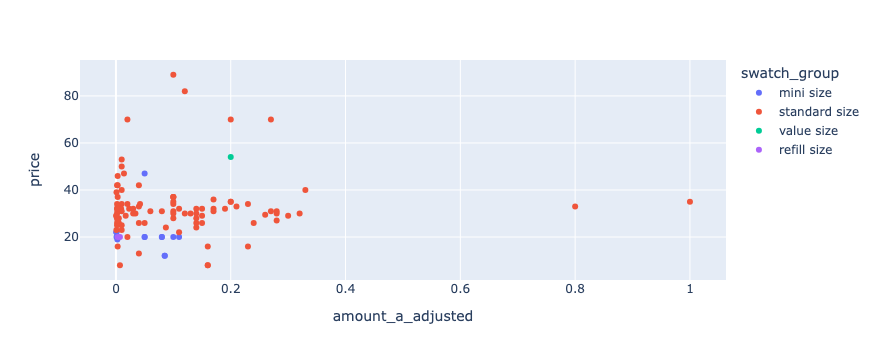

In [264]:
df.head(5)
# https://www.sephora.com/ca/en/product/guerlain-abeille-royale-youth-watery-anti-aging-oil-P474953?skuId=2492858&icid2=products%20grid:p474953:product
# https://www.sephora.com/ca/en/product/highlighter-P404798?skuId=2074532&icid2=products%20grid:p404798:product
# examples of diff product sizes with same name

fig = px.scatter(df[df['lvl_2_cat']=='Eyebrow'], x="amount_a_adjusted", y="price", color="swatch_group", hover_data=['brand_name', 'product_name'])
fig.show()



In [265]:
eligible_products = df[df['swatch_group'].isin(['standard size','mini size'])].groupby(['product_id'], as_index=False)['swatch_group'].count()
df = df.sort_values(by='amount_a',ascending=True)

eligible_products = df[df['swatch_group'].isin(['standard size','mini size'])].groupby(['product_id'], as_index=False)['swatch_group'].count()
eligible_products = eligible_products[eligible_products['swatch_group']==2]['product_id'].values
target_comp_df = df[(df['product_id'].isin(eligible_products)) & (df['swatch_group'].isin(['standard size','mini size']))]
target_comp_df['full_product'] = target_comp_df['brand_name']+' '+ target_comp_df['product_name']

/var/folders/3_/49qq58ns2r11fnng7d9pbd0w0000gn/T/ipykernel_10117/1508495019.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Swatch group comparisons

In [266]:
# target_comp_df = target_comp_df[target_comp_df['brand_name']=='milk makeup']
target_comp_df = target_comp_df[target_comp_df.groupby(['brand_name','product_name'])['swatch_group'].transform(lambda x : x.nunique()>1)]


target_comp_df = target_comp_df.pivot(index=['brand_name','product_name'], columns='swatch_group', values='unit_price')
target_comp_df = target_comp_df.reset_index()
target_comp_df['size_diff'] = target_comp_df['standard size'] - target_comp_df['mini size']
target_comp_df['ratio_mini_to_standard'] = target_comp_df['mini size'] / target_comp_df['standard size']

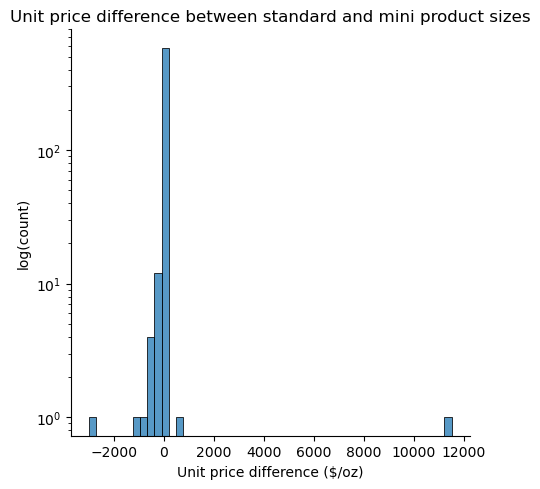

In [267]:
# .hist(bins=50)
# plt.yscale('log')
# plt.grid()

sns.displot(data=target_comp_df, x="size_diff", bins=50)
plt.title('')
plt.yscale('log')
plt.ylabel('log(count)')
plt.title('Unit price difference between standard and mini product sizes')
plt.xlabel('Unit price difference ($/oz)')
plt.tight_layout()
plt.show()

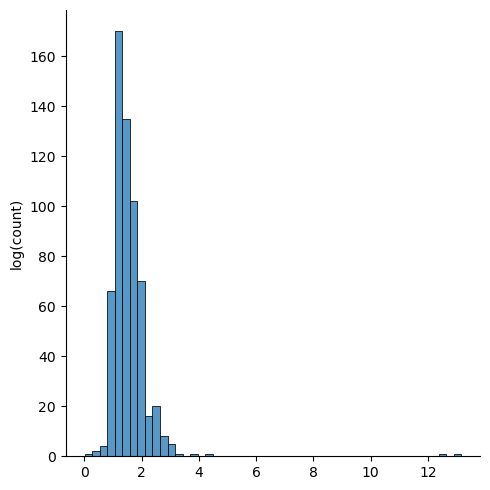

In [268]:


sns.displot(data=target_comp_df, x="ratio_mini_to_standard", bins=50)

plt.ylabel('log(count)')
plt.title('')
plt.xlabel('')
plt.tight_layout()
plt.show()

In [276]:
target_comp_df.sort_values(by=['mini size','ratio_mini_to_standard'], ascending=[True,True]).head(10)

swatch_group,brand_name,product_name,mini size,standard size,size_diff,ratio_mini_to_standard
399,one/size by patrick starrr,fantasize lifting & lengthening mascara,0.730769,71.739130,71.008361,0.010186
333,mario badescu,"facial spray with aloe, chamomile and lavender",2.000000,1.500000,-0.500000,1.333333
334,mario badescu,"facial spray with aloe, cucumber and green tea",2.000000,1.500000,-0.500000,1.333333
335,mario badescu,"facial spray with aloe, herbs and rosewater",2.000000,1.500000,-0.500000,1.333333
332,mario badescu,"facial spray with aloe adaptogens, and coconut...",2.375000,1.750000,-0.625000,1.357143
589,voluspa,havana mint mojito glass jar candle,2.545455,1.333333,-1.212121,1.909091
594,voluspa,tahitian coconut vanilla glass jar candle,2.545455,1.333333,-1.212121,1.909091
440,pattern by tracee ellis ross,hydrating hair mist,3.000000,1.916667,-1.083333,1.565217
438,pattern by tracee ellis ross,curl mousse,3.750000,3.250000,-0.500000,1.153846
437,pattern by tracee ellis ross,curl gel,4.000000,3.265306,-0.734694,1.225000


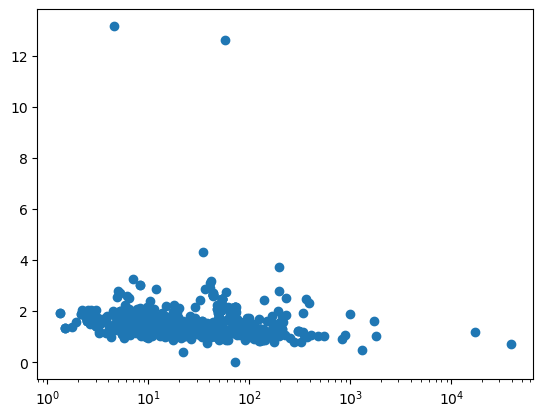

In [277]:
plt.scatter(target_comp_df['standard size'], target_comp_df['ratio_mini_to_standard'])
plt.xscale('log')

In [278]:
target_comp_df = target_comp_df.set_index(['brand_name','product_name']).stack('swatch_group').reset_index().rename(columns={0:'unit_price'})

In [290]:
target_comp_df.brand_name.value_counts().head(20)

oribe                           88
moroccanoil                     88
tarte                           76
benefit cosmetics               72
commodity                       68
living proof                    64
bumble and bumble               60
nest new york                   56
tatcha                          56
fresh                           48
sol de janeiro                  48
skylar                          44
voluspa                         44
hourglass                       40
pattern by tracee ellis ross    36
pureology                       36
drunk elephant                  36
kérastase                       36
charlotte tilbury               36
clean reserve                   36
Name: brand_name, dtype: int64

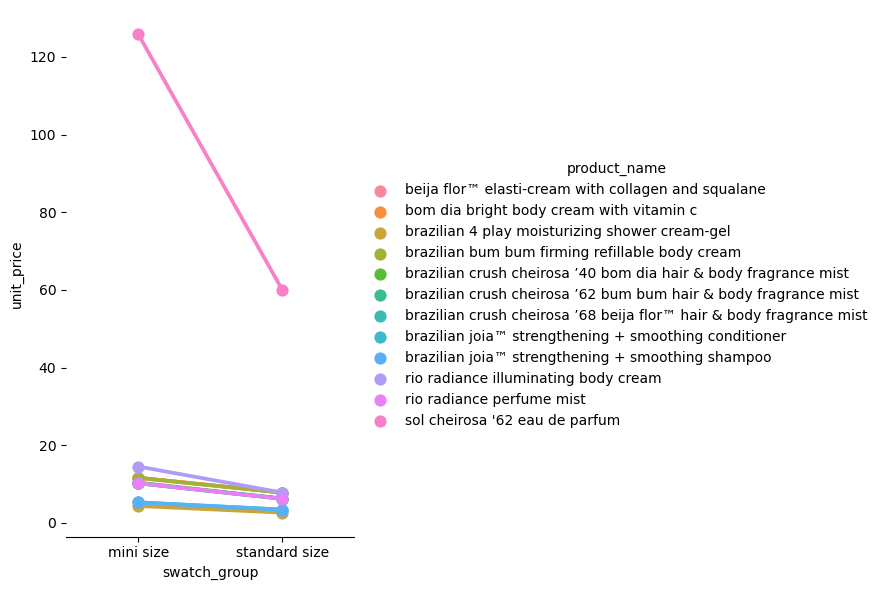

In [292]:
filtered_df = target_comp_df[(~target_comp_df['swatch_group'].isin(['size_diff','ratio_mini_to_standard'])) &
                             (target_comp_df['brand_name']=='sol de janeiro')]
# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(
    data=filtered_df, x="swatch_group", y="unit_price", hue="product_name",
    capsize=.2, #palette="YlGnBu_d",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)

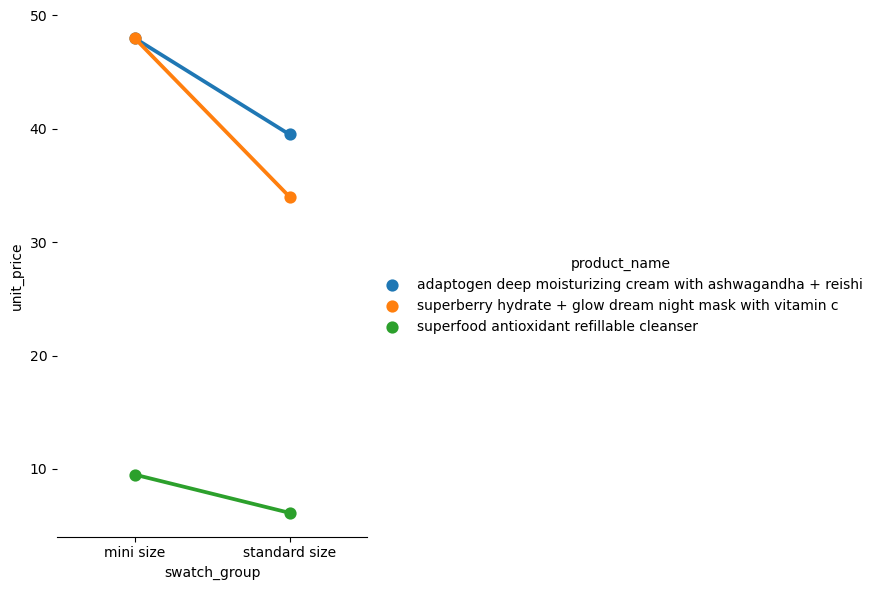

In [82]:
filtered_df = target_comp_df[(target_comp_df['swatch_group']!='size_diff') & (target_comp_df['brand_name']=='youth to the people')]
# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(
    data=filtered_df, x="swatch_group", y="unit_price", hue="product_name",
    capsize=.2, #palette="YlGnBu_d",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)

In [65]:
# in bare minerals - mini size == standard

In [66]:
issue_brands = ['Tom Ford', 'tarte', 'Moroccanoil', 'Dior', 'Anastasia Beverly Hills']
prods = ['clinique']
# url = 'https://www.sephora.com/ca/en/product/charlotte-tilbury-airbrush-flawless-setting-spray-P461147?skuId=2368439&icid2=products%20grid:p461147:product'

# url = 'https://www.sephora.com/ca/en/product/ambient-lighting-blush-collection-P384963?skuId=1581321&icid2=products%20grid:p384963:product'
# lots of options all same size
# url = "https://www.sephora.com/ca/en/product/saie-glowy-super-skin-lightweight-hydrobounce-serum-foundation-P504907?icid2=new_ca_skugrid_ufe:p504907:product"
# ran into issue getting product name
# url = "https://www.sephora.com/ca/en/product/book-personal-travel-spray-P501954?icid2=homepage_productlist_brandnewadditions_ca_rwd_092022"
# value set works
# url = 'https://www.sephora.com/ca/en/product/laneige-midnight-to-morning-hydration-set-P504208?skuId=2639557&icid2=products%20grid:p504208:product'
# hair brush with no ingredients
# url = 'https://www.sephora.com/ca/en/product/sephora-collection-scalp-massager-P472069?skuId=2414555&icid2=products%20grid:p472069:product'
# new prod
# url = 'https://www.sephora.com/ca/en/product/gxve-by-gwen-stefani-check-my-glow-platinum-glow-highlighter-P505655?icid2=new_ca_skugrid_ufe:p505655:product'
# sale prod
# url = 'https://www.sephora.com/ca/en/product/green-microalgae-retinol-regenerating-serum-P506077?skuId=2672301&icid2=products%20grid:p506077:product'
# no reviews yet or ratings

# broken page https://www.sephora.com/ca/en/product/beautyblender-bronze-besties-P505630?skuId=2662559&icid2=products


with open(data_dir+'brand_data.json') as file:
    brand_data = json.loads(file.read())

NameError: name 'data_dir' is not defined

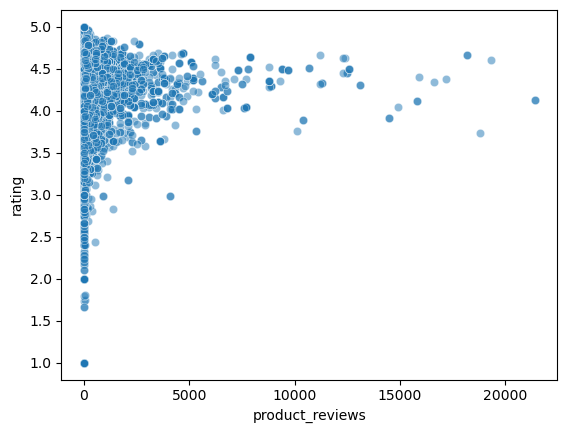

,internal_product_id,url,product_name,brand_name,options,rating,product_reviews,ingredients,n_loves,categories,swatch_group,size,name,price,sku,out_of_stock,limited_edition,new_product,few_left,sale,refill,lvl_0_cat,lvl_1_cat,lvl_2_cat,url_path,url_sku,url_params,product_multiplier,multiplier,amount_a,unit_a,amount_b,unit_b,misc_info,swatch_details,unit_price,product_id
353,144,https://www.sephora.com/ca/en/product/a-tint-o...,brownish hair powder,bumble and bumble,"[{'swatch_group': 'Standard size', 'size': Non...",3.1164,507.0,"Dimethyl Ether, Alcohol Denat., Propylene Glyc...",8500.0,"['Hair', 'Hair Styling & Treatments', 'Dry Sha...",standard size,4.4 oz 130 ml,NaN,50.0,1270388,False,False,False,False,False,False,Hair,Hair Styling & Treatments,Dry Shampoo,/ca/en/product/a-tint-of-brown-hair-powder,1270388,"{'skuId': ['1270388'], 'icid2': ['products gri...",NaN,NaN,4.400,oz,130.00,ml,NaN,standard size,11.363636,280526
1805,1215,https://www.sephora.com/ca/en/product/morphe-m...,make it big brush-tip liquid liner,morphe,"[{'swatch_group': 'Standard size', 'size': 'Si...",2.9583,24.0,"Water (Aqua, Eau), Acrylates Copolymer, Black ...",1300.0,"['Makeup', 'Eye', 'Eyeliner']",standard size,0.019 oz 0.55 ml,color: bold black,16.0,2524718,False,False,False,False,False,False,Makeup,Eye,Eyeliner,/ca/en/product/morphe-make-it-big-brush-tip-li...,2524718,"{'skuId': ['2524718'], 'icid2': ['products gri...",NaN,NaN,0.019,oz,0.55,ml,NaN,standard size,842.105263,476714


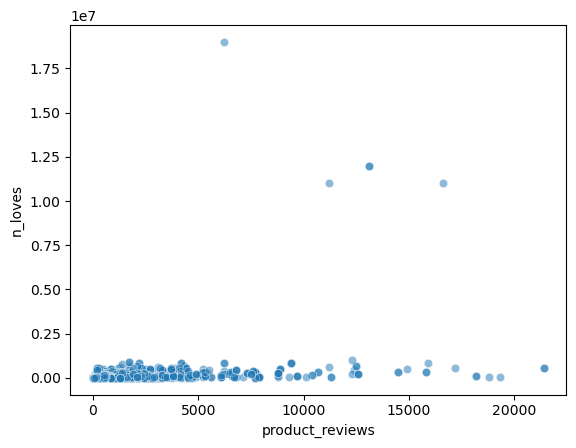

array(['cream lip stain liquid lipstick', 'radiant creamy concealer',
       'lip sleeping mask intense hydration with vitamin c',
       'soft pinch liquid blush'], dtype=object)

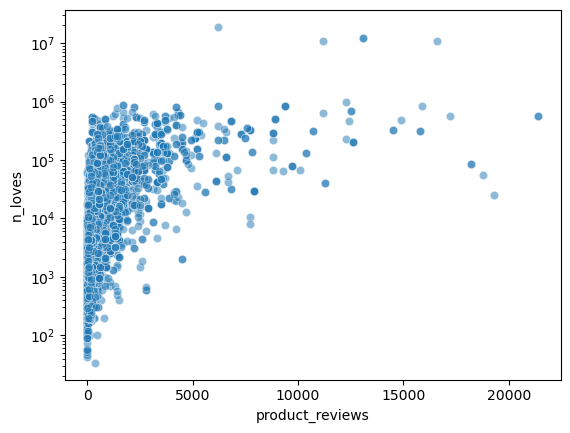

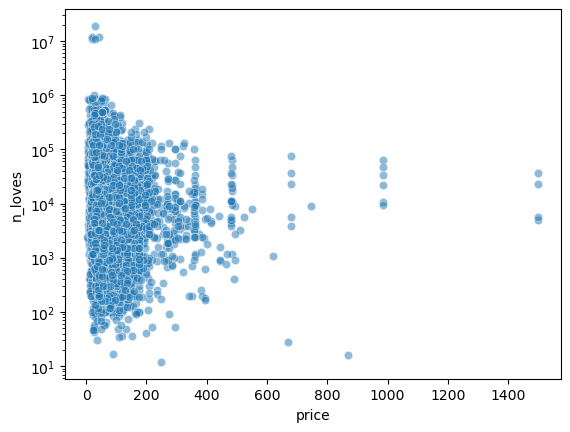

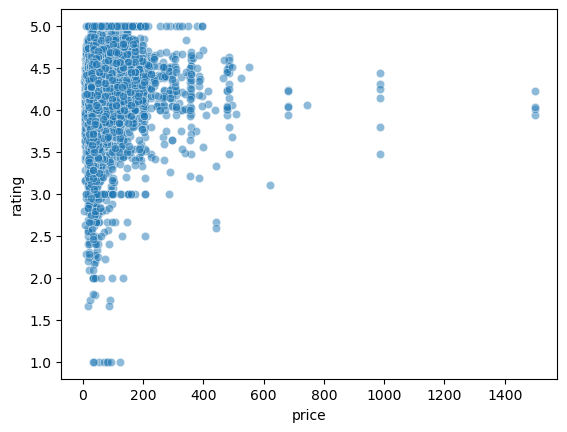

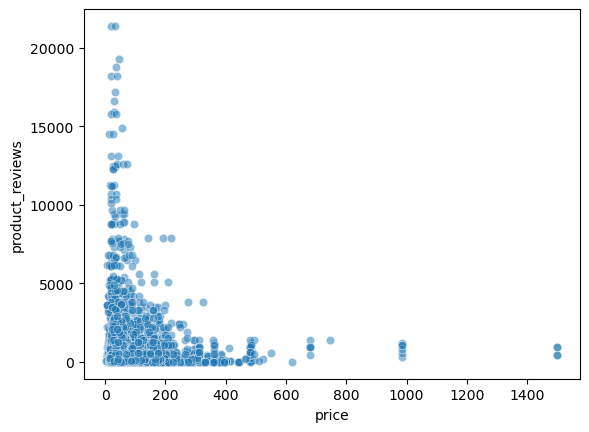

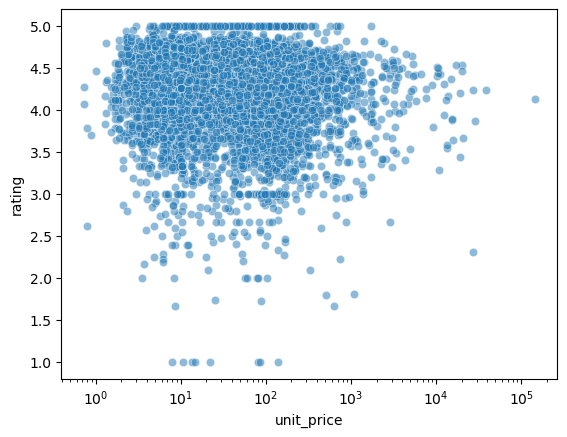

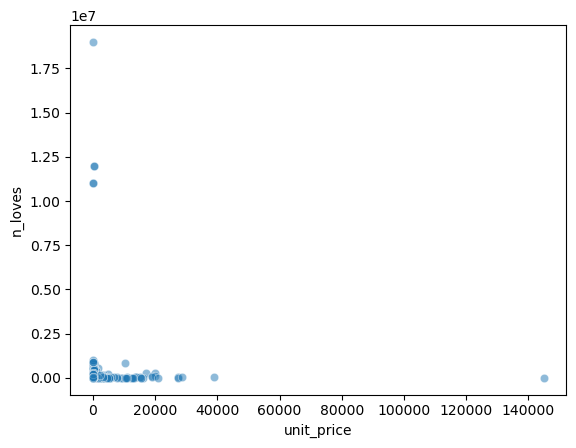

In [148]:

# df_products
# EDA - what is the distribution of product reviews
# scatter reviews v ratings

sns.scatterplot(data=df, x="product_reviews", y="rating", alpha=0.5)
plt.show()
# how many products have no reviews?
# interesting outliers - looked at reviews, truly bad
display(df_products[(df['product_reviews']>4000) & (df_products['rating']<3.2)])


# scattr review v loves
# the handful of outliers are so interesting
# was there a promotion to add these to loves list?
sns.scatterplot(data=df, x="product_reviews", y="n_loves", alpha=0.5)
plt.show()
display(df[(df['n_loves']>1500000)]['product_name'].unique())
sns.scatterplot(data=df, x="product_reviews", y="n_loves", alpha=0.5)
plt.yscale('log')
plt.show()
# scatter n loves v price 
sns.scatterplot(data=df, x="price", y="n_loves", alpha=0.5)
plt.yscale('log')
plt.show()


sns.scatterplot(data=df, x="price", y="rating", alpha=0.5)
plt.show()

sns.scatterplot(data=df, x="price", y="product_reviews", alpha=0.5)
plt.show()

sns.scatterplot(data=df[df['unit_a']=='oz'], x="unit_price", y="rating", alpha=0.5)
plt.xscale('log')
plt.show()

sns.scatterplot(data=df[df['unit_a']=='oz'], x="unit_price", y="n_loves", alpha=0.5)
plt.show()